In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima_process import ArmaProcess
from datetime import datetime, timedelta


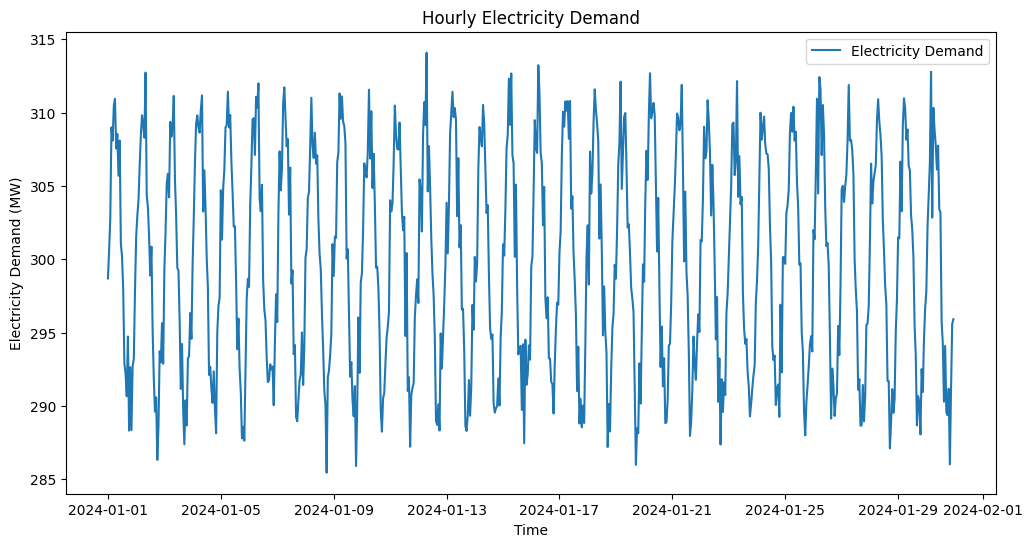

In [38]:
# Generate some data
np.random.seed(1926)
n_hours = 24 * 30  # 30 days of hourly data
time_index = pd.date_range(start='2024-01-01', periods=n_hours, freq='h')

# Create a trend, seasonality, and noise
seasonality = 10 * np.sin(2 * np.pi * np.arange(n_hours) / 24)  # Daily seasonality
noise = np.random.normal(0, 2, size=n_hours)  # Random noise
demand = 300 + seasonality + noise

# Convert to a Pandas Series
demand_series = pd.Series(demand, index=time_index)
demand_series.name = "Electricity Demand (MW)"

# Plot the synthetic data
plt.figure(figsize=(12, 6))
plt.plot(demand_series, label="Electricity Demand")
plt.title("Hourly Electricity Demand")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (MW)")
plt.legend()
plt.show()


In [39]:
# Split the data into training and test sets 
train_size = int(len(demand_series) * 0.8)
train, test = demand_series[:train_size], demand_series[train_size:]

In [40]:
# Step 1. Check if series are stationary
result = adfuller(train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.055241058379778
p-value: 5.396468719374636e-10


ADF Statistic (D=1): -24.6742141869171
p-value (D=1): 0.0


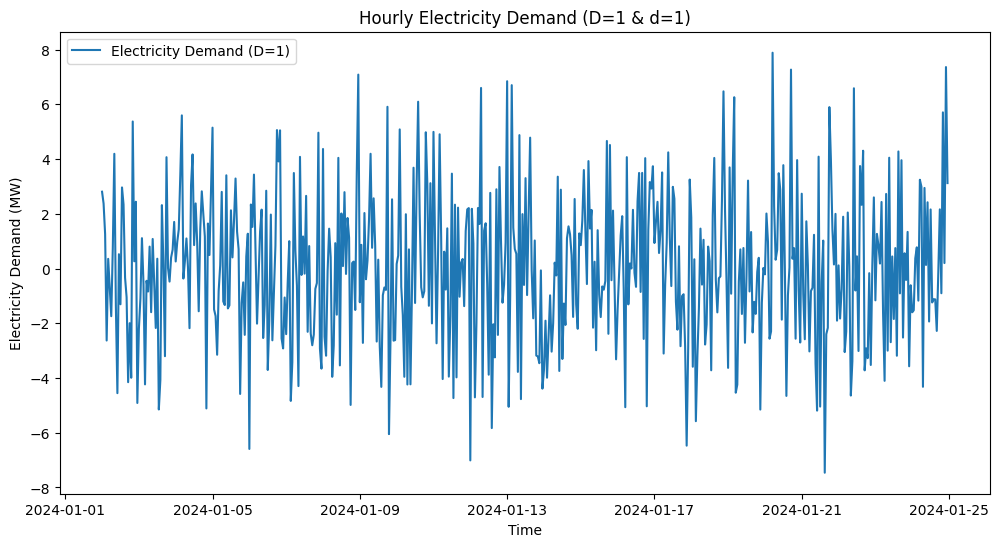

In [46]:
# Step 2. Apply seasonal differencing with s=24 for hourly data
demand_seasonally_differenced = train - train.shift(24)

result_diff1_1 = adfuller(demand_seasonally_differenced.dropna())
print(f'ADF Statistic (D=1): {result_diff1_1[0]}')
print(f'p-value (D=1): {result_diff1_1[1]}')

plt.figure(figsize=(12, 6))
plt.plot(demand_seasonally_differenced, label="Electricity Demand (D=1)")
plt.title("Hourly Electricity Demand (D=1 & d=1)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (MW)")
plt.legend()
plt.show()

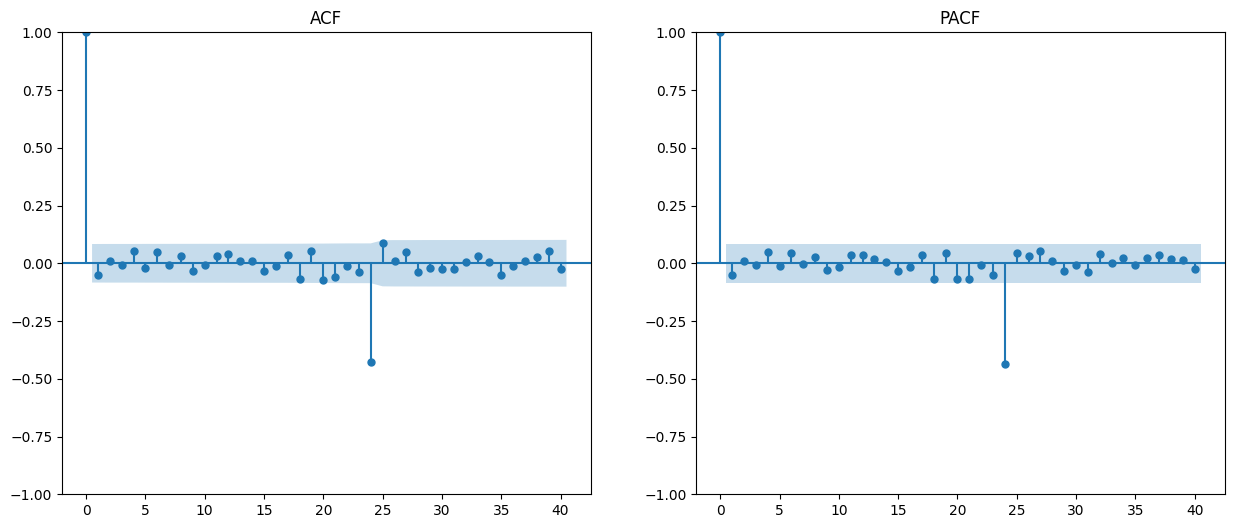

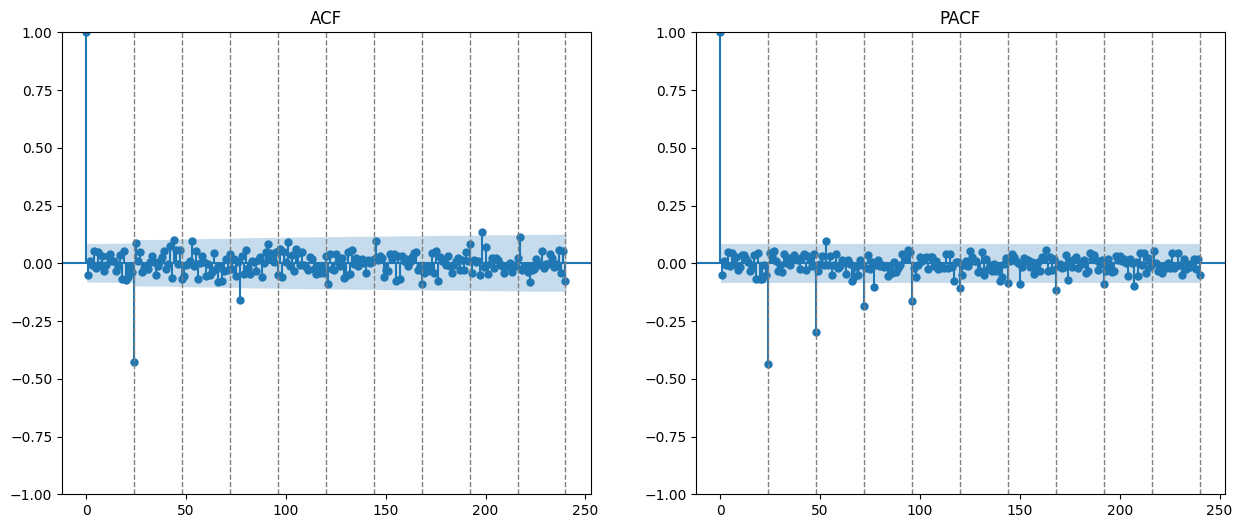

In [47]:
# Step 3. Check ACF and PACF

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sm.graphics.tsa.plot_acf(demand_seasonally_differenced.dropna(), lags=40, ax=axs[0])
axs[0].set_title('ACF')
sm.graphics.tsa.plot_pacf(demand_seasonally_differenced.dropna(), lags=40, ax=axs[1])
axs[1].set_title('PACF')
plt.show()


max_lag= 24*10
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sm.graphics.tsa.plot_acf(demand_seasonally_differenced.dropna(), lags=max_lag, ax=axs[0])
axs[0].set_title('ACF')
for i in range(24, max_lag+1, 24):  
    axs[0].axvline(x=i, color='grey', linestyle='--', lw=1)
sm.graphics.tsa.plot_pacf(demand_seasonally_differenced.dropna(), lags=max_lag, ax=axs[1])
axs[1].set_title('PACF')
for i in range(24, max_lag+1, 24): 
    axs[1].axvline(x=i, color='grey', linestyle='--', lw=1)

plt.show()

In [45]:
# Fit our guess at a model
model = SARIMAX(train, 
                order=(0, 0, 0),               # Non-seasonal ARIMA(p, d, q)
                seasonal_order=(5, 1, 1, 24))  # Seasonal SARIMA(P, D, Q, s)            

model_fit = model.fit()

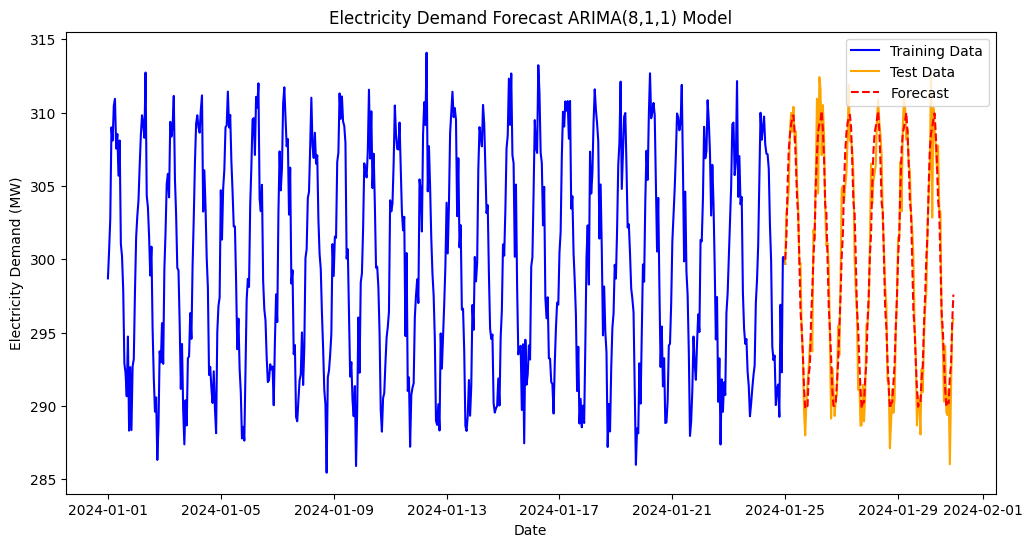

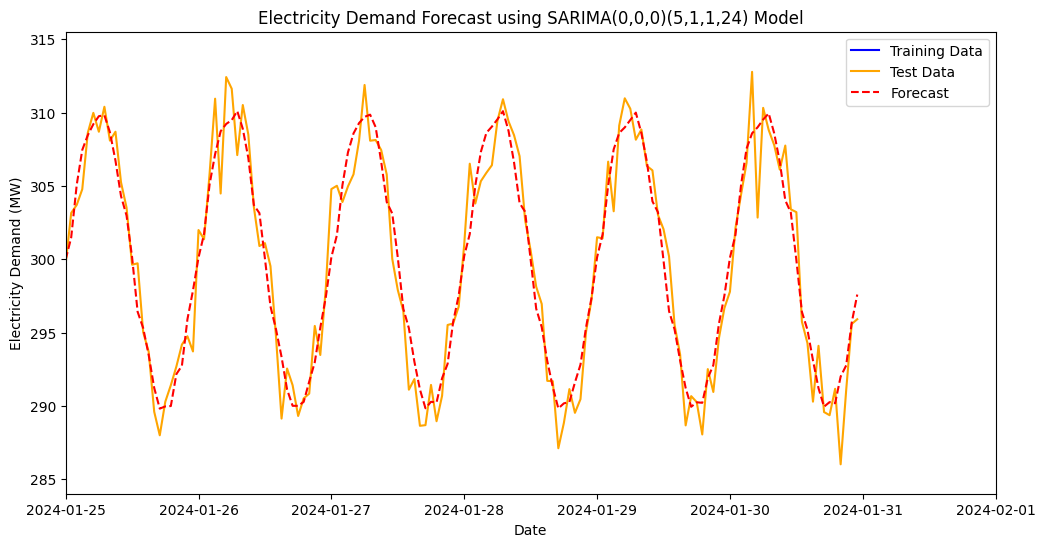

In [50]:
# Step 6: Forecast
n_forecast = len(test) 
forecast = model_fit.get_forecast(steps=n_forecast)

# Extract forecasted mean values
forecast_mean = forecast.predicted_mean

# Use the test index for the forecast
forecast_index = test.index

# Convert forecasted mean values into a pandas Series with the appropriate index
forecast_series = pd.Series(forecast_mean, index=forecast_index)

# Extend the training data with the first value of the test set for visualisation
first_test_value = pd.Series([test.iloc[0]], index=[test.index[0]])
extended_train = pd.concat([train, first_test_value])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(extended_train.index, extended_train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red', linestyle='--')  
plt.title('Electricity Demand Forecast ARIMA(8,1,1) Model') 
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

# Optionally, if you want to limit the time range for plotting
plt.figure(figsize=(12, 6))
plt.plot(extended_train.index, extended_train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red', linestyle='--') 
plt.xlim([pd.Timestamp('2024-01-25'), pd.Timestamp('2024-02-01')]) 
plt.title('Electricity Demand Forecast using SARIMA(0,0,0)(5,1,1,24) Model') 
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()


In [49]:
model = auto_arima(train, seasonal=True,m=24,D=1,d=0,stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=inf, Time=5.43 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2683.202, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=2568.704, Time=1.83 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2681.232, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=2683.717, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=2509.018, Time=4.34 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=9.46 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=3.25 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=2508.116, Time=3.39 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=2567.885, Time=1.23 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=2509.044, Time=4.78 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=2510.9